In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

In [10]:
df = pd.read_csv('../data/dataset/esol.csv')

In [11]:
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(df['expt'], df['calc'], 'o', alpha=.6, markersize=3)
x = np.linspace(-30, 5, 100)
plt.plot(x, x)

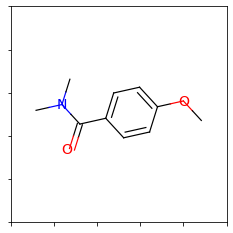

In [5]:
smiles = df['smiles']
m = Chem.MolFromSmiles(smiles[0])
fig = Draw.MolToMPL(m, size=(120, 120))

In [15]:
all_atom_names = []
all_hydrogens = []

for i, smile in enumerate(smiles):
    m = Chem.MolFromSmiles(smile)
    atom_names = [a.GetSymbol() for a in m.GetAtoms()]
    hydrogens = [a.GetImplicitValence() for a in m.GetAtoms()]
    all_atom_names += atom_names
    all_hydrogens += hydrogens
    
atom_dict = {}
for i, a in enumerate(list(Counter(all_atom_names))):
    atom_dict[a] = i
    
max_hydrogen = max(Counter(all_hydrogens).keys())

4


In [25]:
node_data = []
adj_data = []
target_data = []

expt = df['expt']

for i, smile in enumerate(smiles):
    m = Chem.MolFromSmiles(smile)
    atom_names = [a.GetSymbol() for a in m.GetAtoms()]
    hydrogen_nums = [a.GetImplicitValence() for a in m.GetAtoms()]
    
    node = []
    for j, (a, h) in enumerate(zip(atom_names, hydrogen_nums)):
        node_atom_names = np.zeros(len(atom_dict))
        node_hydrogens = np.zeros(max_hydrogen+1)
        
        node_atom_names[atom_dict[a]] += 1
        node_hydrogens[h] += 1
        node.append(node_atom_names)
    node = np.array(node)
        
    adj = GetAdjacencyMatrix(m)
    
    node_data.append(torch.from_numpy(node).float())
    adj_data.append(torch.from_numpy(adj + np.eye(len(adj))).float())
    target_data.append(torch.FloatTensor([expt[i]]))

In [26]:
dataset = []
dataset.append(node_data)
dataset.append(adj_data)
dataset.append(target_data)

In [27]:
torch.save(dataset, '../dataset/freesolv.pt')